In [2]:
import warnings
warnings.filterwarnings('ignore')

In [132]:
#Dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import gmaps
import os
import scipy.stats as stats
from scipy.stats import linregress

# 1. Import & Clean Datasets

###  1.1 Crime and Incarceration in the United States (2001-2016)
Column Header Descriptions:
* **jurisdiction:** State / federal jurisdiction<br/>
* **includes_jails:** Indicates if prisoner totals include jails<br/>
* **prisoner_count:** Year-end count of prisoners in custody<br/>
* **crime_reporting_change:** Indicates whether state changed reporting systems affecting comparisons with previous years<br/>
* **crimes_estimated:** Indicates if some crime totals are estimated<br/><br/>

Addt'l Considerations
* Does not include Puerto Rico or D.C., census does

[Source](https://www.kaggle.com/christophercorrea/prisoners-and-crime-in-united-states)<br/>

In [10]:
#Import crime data
crime_file = pd.read_csv('Resources/crime_and_incarceration_by_state.csv')
crime_df = pd.DataFrame(crime_file)

#calculate 'total crimes' column
crime_df['Total Crime'] = crime_df['violent_crime_total'] + crime_df['property_crime_total']

#Reorganize columns and remove unnecessary columns
crime_df = crime_df[['jurisdiction','year','prisoner_count','Total Crime']]

#rename columns
crime_df = crime_df.rename(columns = {'jurisdiction' : 'State',
                                      'year' : 'Year',
                                      'prisoner_count' : 'Prisoner Population',})

#Formate the state string to match census' state header
crime_df['State'] = crime_df['State'].str.title()

crime_df.head()

,State,Year,Prisoner Population,Total Crime
0,Federal,2001,149852,NaN
1,Alabama,2001,24741,192835.0
2,Alaska,2001,4570,26895.0
3,Arizona,2001,27710,322549.0
4,Arkansas,2001,11489,111296.0


### 1.2 Census Data (2009-2018)
[Source](https://www.census.gov/data/developers/data-sets/acs-5year.html)<br/>

In [8]:
#Import US population data (census)
pop_file = pd.read_csv('Resources/pop_data.csv')
pop_df = pd.DataFrame(pop_file)
pop_df.head()

,State,Year,Total Population
0,Alaska,2009,683142
1,Alabama,2009,4633360
2,Arkansas,2009,2838143
3,Arizona,2009,6324865
4,California,2009,36308527


### 1.3 Census Regions and Divisions of the United States
[Source](https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf)

In [95]:
regions_file = pd.read_csv('Resources/regions.csv')
regions_df = pd.DataFrame(regions_file)
regions_df.head()

# 2. Create Secondary Datasets

### 2.1 Merge Crime and Census Data

In [29]:
#Merge census and crime dataframes on state and year
us_crime = pd.merge(crime_df,pop_df, on=['State','Year'])

#calculate incarceration rate column
us_crime['Incarceration Rate (%)'] = round(us_crime['Prisoner Population']/us_crime['Total Population'],5)*100
us_crime.head()

#crime_pop

,State,Year,Prisoner Population,Total Crime,Shifted,Total Population,Incarceration Rate (%)
0,Alabama,2009,27241,199201.0,25363.0,4633360,0.588
1,Alaska,2009,5472,24962.0,4997.0,683142,0.801
2,Arizona,2009,40544,264849.0,39455.0,6324865,0.641
3,Arkansas,2009,13338,123983.0,13135.0,2838143,0.470
4,California,2009,168830,1184367.0,171085.0,36308527,0.465


### 2.2 Create Region Dataframe (2016 only)

In [177]:
filter_2016 = us_crime[us_crime['Year'] == 2016]

region_crime = pd.merge(filter_2016,regions_df, on=['State'])
region_crime = region_crime[['Region','Sub Region','State','Prisoner Population', 'Total Crime', 'Total Population', 'Incarceration Rate (%)']]
region_crime.sort_values(['Region'], inplace=True)

region_crime.to_csv('Output/region_crime.csv', index=False)

region_crime.head()

,Region,Sub Region,State,Prisoner Population,Total Crime,Total Population,Incarceration Rate (%)
24,Midwest,West North Central,Missouri,32427,202381.0,6059651,0.535
48,Midwest,East North Central,Wisconsin,23163,129627.0,5754798,0.402
22,Midwest,West North Central,Minnesota,9509,131088.0,5450868,0.174
21,Midwest,East North Central,Michigan,41122,236031.0,9909600,0.415
33,Midwest,West North Central,North Dakota,1639,19356.0,736162,0.223


### 2.3 Released Population

In [43]:
#Create new column that shifts total pop down by 1 then calculate the change
crime_df['Shifted'] = crime_df.groupby('State')['Prisoner Population'].shift(1)
release = crime_df.groupby(['Year']).sum()
release['Release Rate'] = round((release['Prisoner Population'] - release['Shifted'])/release['Prisoner Population']*100,3)

#drop 2001 (first year) data
release = release.drop(release.index[0])

#reset indices
release.reset_index()

,Year,Prisoner Population,Total Crime,Shifted,Release Rate
0,2002,1367361,11833155.0,1329806.0,2.747
1,2003,1394115,11784781.0,1367361.0,1.919
2,2004,1421816,11644988.0,1394115.0,1.948
3,2005,1447435,11531334.0,1421816.0,1.770
4,2006,1488380,11418888.0,1447435.0,2.751
5,2007,1513390,11267935.0,1488380.0,1.653
6,2008,1522953,11129893.0,1513390.0,0.628
7,2009,1524650,10626372.0,1522953.0,0.111
8,2010,1521413,10327045.0,1524650.0,-0.213
9,2011,1504986,10221687.0,1521413.0,-1.092


# 3. Data Analysis (Exploration & Visuals)

### Nationawide Analysis

In [18]:
def linePlotDualY_grouped(group_column,
                          ax1_df,ax1_column, ax1_label, ax1_color,
                          ax2_df,ax2_column, ax2_label, ax2_color,
                          chart_title):
    fig, ax1 = plt.subplots()
    ax1_group = ax1_df.groupby([group_column]).sum()[ax1_column]
    ax1.plot(ax1_group, color=ax1_color, label = ax1_label)
    ax1.set_ylabel(ax1_column, color=ax1_color)

    ax2 = ax1.twinx()
    ax2_group = ax2_df.groupby([group_column]).sum()[ax2_column]
    ax2.plot(ax2_group, color=ax2_color, label = ax2_label)
    ax2.set_ylabel(ax2_label, color=ax2_color)

    plt.grid()
    ax1.set_xlabel(group_column)
    plt.title(f'{ax1_label} vs. {ax2_label} (Nationwide)')
    
    plt.tight_layout()

    plt.savefig(f'Output/{chart_title}.png')

    plt.show()

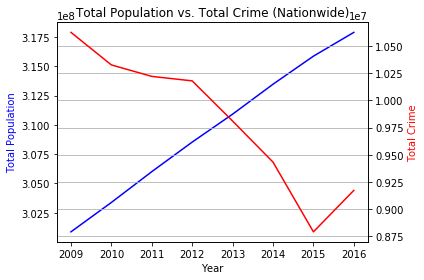

In [19]:
linePlotDualY_grouped('Year',
                      us_crime,'Total Population', 'Total Population', 'b',
                      us_crime,'Total Crime', 'Total Crime', 'r',
                     'Total Population vs. Total Crime')

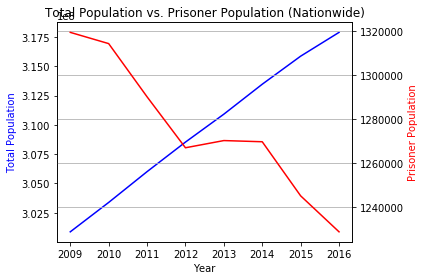

In [21]:
linePlotDualY_grouped('Year',
                      us_crime,'Total Population', 'Total Population', 'b',
                      us_crime,'Prisoner Population', 'Prisoner Population', 'r',
                     'Total Population vs. Prisoner Population')

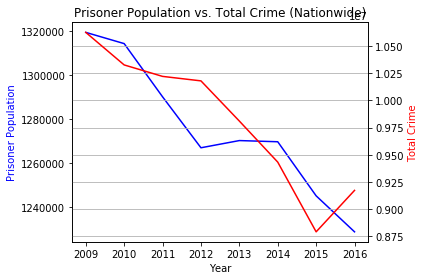

In [20]:
linePlotDualY_grouped('Year',
                      us_crime,'Prisoner Population', 'Prisoner Population', 'b',
                      us_crime,'Total Crime', 'Total Crime', 'r',
                      'Total Crime vs. Toatl Prisoner Pop.')

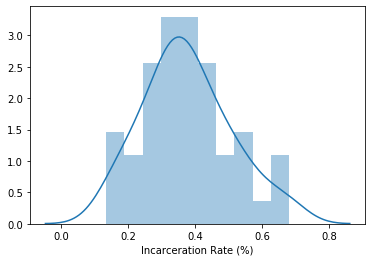

In [31]:
sns.distplot(filter_2016['Incarceration Rate (%)'], kde=True, bins=10)
plt.savefig('Output/released_pop.png')

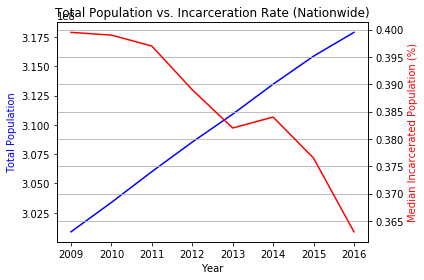

In [33]:
fig, ax1 = plt.subplots()
yearly_crime = us_crime.groupby(['Year']).sum()['Total Population']
ax1.plot(yearly_crime, color='b')
ax1.set_ylabel('Total Population', color='b')

ax2 = ax1.twinx()
yearly_prisoner = us_crime.groupby(['Year']).median()['Incarceration Rate (%)']
ax2.plot(yearly_prisoner, color='r')
ax2.set_ylabel('Median Incarcerated Population (%)', color='r')


ax1.set_xlabel('Year')
plt.title('Total Population vs. Incarceration Rate (Nationwide)')

plt.grid()
plt.tight_layout()

plt.savefig('Output/pop_vs_incar_.png')

plt.show()

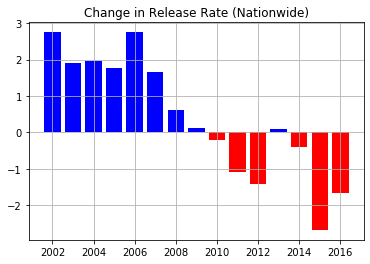

In [44]:
pos = release[release["Release Rate"] > 0]
neg = release[release["Release Rate"] < 0]


plt.bar(pos.index, pos["Release Rate"], color='b')
plt.bar(neg.index, neg["Release Rate"], color='r')
plt.title('Change in Release Rate (Nationwide)')
plt.grid() 
plt.savefig('Output/released_pop.png')

plt.show()

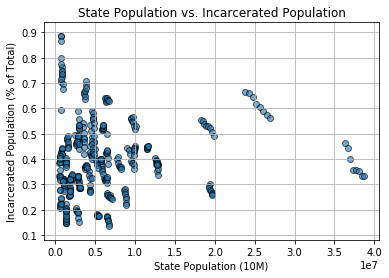

In [54]:
plt.scatter(us_crime['Total Population'], us_crime['Incarceration Rate (%)'], edgecolor = 'black', alpha = 0.6)
plt.title(f'State Population vs. Incarcerated Population')
plt.xlabel('State Population (10M)')
plt.ylabel('Incarcerated Population (% of Total)')
plt.grid()

plt.savefig('Output/pop_vs_incar_pop.png')

plt.show()

### Regions Analysis

In [153]:
sub_group = region_crime.groupby(['Sub Region']).sum()
sub_group['Incarceration Rate (%)'] = round(sub_group['Prisoner Population']/sub_group['Total Population'],5)*100
sub_group.sort_values(['Incarceration Rate (%)'], inplace = True)
sub_group

,Prisoner Population,Total Crime,Total Population,Incarceration Rate (%)
Sub Region,,,,
New England,33655,283992.0,14668879,0.229
Mid Atlantic,118356,802195.0,41396890,0.286
Pacific,170783,1663307.0,51860147,0.329
West North Central,71214,591542.0,20983879,0.339
East South Central,70871,601892.0,18790354,0.377
East North Central,185216,1216648.0,46692601,0.397
Mountain,99936,779529.0,23200043,0.431
South Atlantic,270140,1911954.0,61860194,0.437
West South Central,208535,1322464.0,38446166,0.542


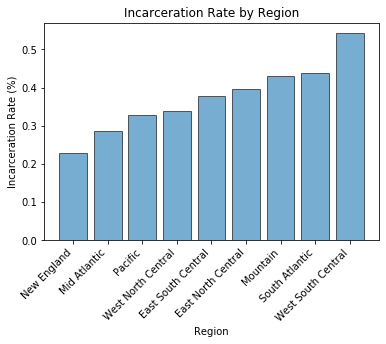

In [154]:
plt.bar(sub_group.index, sub_group['Incarceration Rate (%)'], edgecolor = 'black', alpha = 0.6)
plt.title(f'Incarceration Rate by Region')
plt.xlabel('Region')
plt.ylabel('Incarceration Rate (%)')

plt.xticks(rotation=45, ha='right')
plt.savefig('Output/region_vs_incar_rate.png')
plt.show()

In [155]:
region_group = region_crime.groupby(['Region']).sum()
region_group['Incarceration Rate (%)'] = round(region_group['Prisoner Population']/region_group['Total Population'],5)*100
region_group.sort_values(['Incarceration Rate (%)'], inplace = True)
region_group

,Prisoner Population,Total Crime,Total Population,Incarceration Rate (%)
Region,,,,
Northeast,152011,1086187.0,56065769,0.271
West,270719,2442836.0,75060190,0.361
Midwest,256430,1808190.0,67676480,0.379
South,549546,3836310.0,119096714,0.461


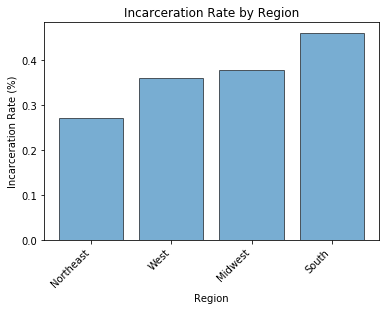

In [156]:
plt.bar(region_group.index, region_group['Incarceration Rate (%)'], edgecolor = 'black', alpha = 0.6)
plt.title(f'Incarceration Rate by Region')
plt.xlabel('Region')
plt.ylabel('Incarceration Rate (%)')

plt.xticks(rotation=45, ha='right')

plt.savefig('Output/region_vs_incar_rate.png')

plt.show()

# 4. Statistical Test

In [169]:
region_crime.head()

,Region,Sub Region,State,Prisoner Population,Total Crime,Total Population,Incarceration Rate (%)
20,Northeast,New England,Massachusetts,9038,132405.0,6742143,0.134
43,West,Mountain,Utah,4502,97967.0,2948427,0.153
22,Midwest,West North Central,Minnesota,9509,131088.0,5450868,0.174
18,Northeast,New England,Maine,2356,23557.0,1329923,0.177
28,Northeast,New England,New Hampshire,2599,22991.0,1327503,0.196


F_onewayResult(statistic=5.114364150439532, pvalue=0.0038831351683559644)

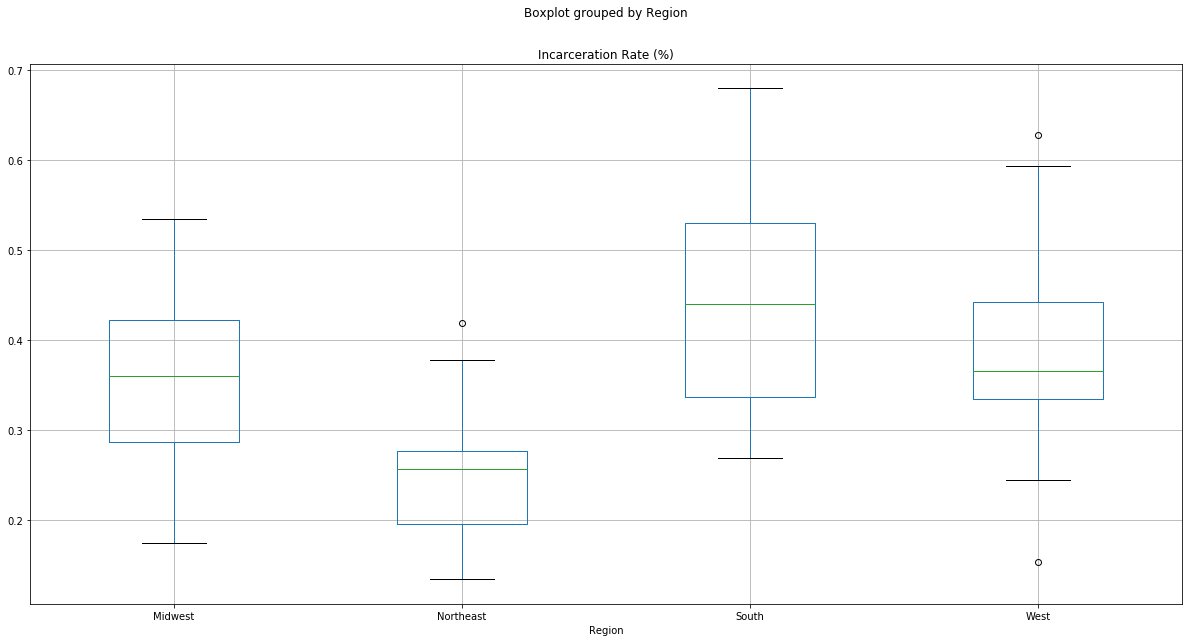

In [170]:
#region_crime Incarceration Rate (%)
# Create a boxplot to compare means
region_crime.boxplot('Incarceration Rate (%)', by='Region', figsize=(20, 10))
plt.ylabel('Incarceration Rate (%)')
plt.title('Incarceration Rate by Region - 2016')

plt.savefig('Output/region_box.png')

# Extract individual groups
group1 = region_crime[region_crime['Region'] == 'South']["Incarceration Rate (%)"]
group2 = region_crime[region_crime['Region'] == 'Northeast']["Incarceration Rate (%)"]
group3 = region_crime[region_crime['Region'] == 'Midwest']["Incarceration Rate (%)"]
group4 = region_crime[region_crime['Region'] == 'West']["Incarceration Rate (%)"]


# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4)

F_onewayResult(statistic=2.400450969168164, pvalue=0.03177104915420652)

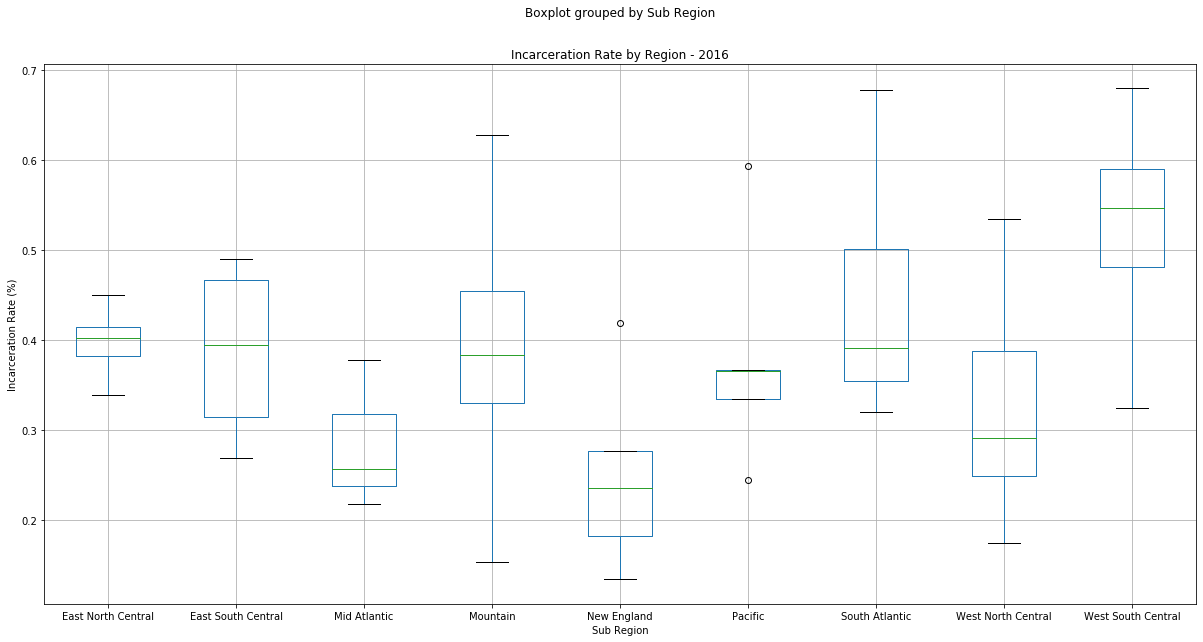

In [175]:
# Create a boxplot to compare means
region_crime.boxplot('Incarceration Rate (%)', by='Sub Region', figsize=(20, 10))
plt.ylabel('Incarceration Rate (%)')
plt.title('Incarceration Rate by Region - 2016')

plt.savefig('Output/sub_box.png')

# Extract individual groups
group1 = region_crime[region_crime['Sub Region'] == 'Mid Atlantic']["Incarceration Rate (%)"]
group2 = region_crime[region_crime['Sub Region'] == 'Mountain']["Incarceration Rate (%)"]
group3 = region_crime[region_crime['Sub Region'] == 'Pacific']["Incarceration Rate (%)"]
group4 = region_crime[region_crime['Sub Region'] == 'South Atlantic']["Incarceration Rate (%)"]
group5 = region_crime[region_crime['Sub Region'] == 'New England']["Incarceration Rate (%)"]
group6 = region_crime[region_crime['Sub Region'] == 'East North Central']["Incarceration Rate (%)"]
group7 = region_crime[region_crime['Sub Region'] == 'East South Central']["Incarceration Rate (%)"]
group8 = region_crime[region_crime['Sub Region'] == 'West North Central']["Incarceration Rate (%)"]
group9 = region_crime[region_crime['Sub Region'] == 'West South Central']["Incarceration Rate (%)"]

# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4, group5, group6, group7, group8, group9)